<p align="center" style="font-size: large">An overview of the common zero-dimensional SEI models:</p>

Zero-dimensional growth models neglect most of the complexity of the SEI and instead model a single 'limiting' mechanism (e.g., diffusion of a single species). Without considering any other degradation mechanisms, the total current density is given by:

$$J_\mathrm{tot} = J_\mathrm{int} + J_\mathrm{SEI},$$
where $J_\mathrm{int}$ is the intercalation current density (usually described by the Butler-Volmer equation), and $J_\mathrm{SEI}$ represents the capacity fade proportional to the SEI thickness growth. Different $J_\mathrm{SEI}$ expressions are derived or proposed for different limiting mechanisms

Common Zero-dimenional models:

1. Reaction Limited: $J_\mathrm{SEI} = - j_{{SEI},0} \exp \left ( -\alpha_n \frac{F}{RT} \eta_{SEI} \right )$

2.  Electron Migration Limited: $J_\mathrm{SEI}=\frac{\sigma_{SEI} \eta_{SEI}}{L_{SEI}}$

3. Interstitial Diffusion Limited: $ J_\mathrm{SEI} = - \frac{F D_\mathrm{Li}}{L_\mathrm{SEI}} C_\mathrm{Li}\exp \left ( -\alpha_n \frac{F}{RT} \Delta \phi \right )$
    
4. Solvent Diffusion limited: $ J_\mathrm{SEI}=-\frac{-D_{sol} c_{sol} F}{L_{SEI}} $
5.  EC reaction Limited $ J_\mathrm{SEI}= -F k_{\mathrm{sei,0}} C_\mathrm{EC} \exp \left ( -\alpha_n \frac{F}{RT} \eta_{SEI} \right ), \ \ D_\mathrm{EC} \frac{C_\mathrm{EC}- C_\mathrm{EC}^0}{L_\mathrm{SEI}} = \frac{J_\mathrm{SEI}}{F} $


<div class="alert alert-block alert-danger">
Don't run all the cells at once as it may take a long time. Each cell is independently designed for a specific output.
</div>

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np


# Different set of parameters can be used in pybamm
param = pybamm.ParameterValues("Chen2020")

param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12


# CHarging and discharging protocol
cycle_no = 5
c_rates = [5, 10, 30, 50]
rest1 = 10
rest2 = 10
exp_CCCVs = [pybamm.Experiment(
    [("Charge at C/{} until 4.2 V".format(c_rate),
      "Rest for {} hours".format(rest1),
      "Discharge at C/{} until 2.5 V".format(c_rate),
      "Rest for {} hours".format(rest2),
      )] * cycle_no
)for c_rate in c_rates]

# SEI models in the pybamm
sei_models = ["ec reaction limited", "reaction limited",
              "solvent-diffusion limited", "interstitial-diffusion limited", "electron-migration limited"]
sei_models_Label = ["EC-RL", "RL", "S-DL", "I-DL", "E-ML"]


# Any common model DFN, SPMe, or SPM can be used the produce same results at low C-rates
models_SPM = [pybamm.lithium_ion.SPM(options={
    "SEI": sei_models[index],
    "SEI porosity change": "false",
},
    name=sei_models[index]) for index in range(len(sei_models))
]

# You may need to increase maximum number steps as follows:
pybamm.settings.max_y_value = 1000000000
solver = pybamm.CasadiSolver(mode="safe")
# solver = pybamm.IDAKLUSolver()
sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp_CCCV, solver=solver) for model in models_SPM for exp_CCCV in exp_CCCVs]
sols = [sim.solve(initial_soc=0) for sim in sims]

/home/kawamanmi/Projects/PyBaMM


These plots compare the SEI thickness during the first and second cycles across different SEI models at various C-rates.

Note: The SEI growth (L_sei) and the time for each cycle have been adjusted to start from zero.

Observations:

1. In the RL model, L_sei in the first and second cycles remains unchanged even  C-rate changes 
2. In the S-DL model, surprisingly, the trend of SEI growth is consistent for all C-rates in the first cycle but diverges in the second cycle

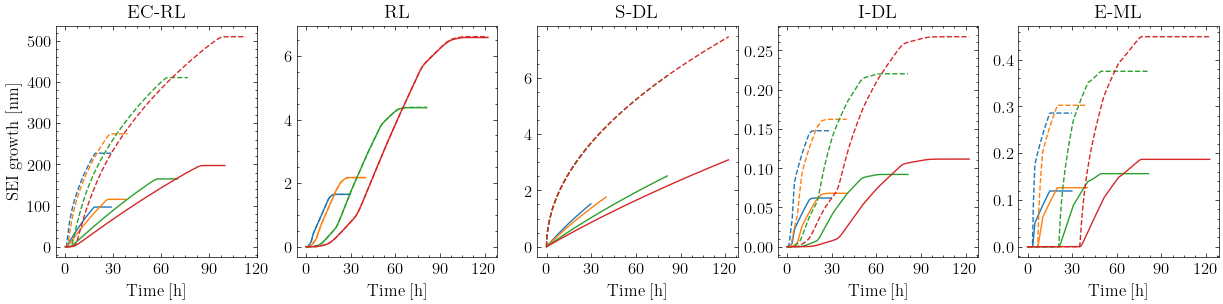

In [5]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.cm as cm
import numpy as np

plt.style.use('science')  # Use the 'science' style
cmap = cm.get_cmap('tab10')  # Colour map (there are many others)

plt.rcParams["font.family"] = "DejaVu Sans"
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
k = 0
line_styles = ["--", "-"]

for i, model in enumerate(sei_models):
    for j, c_rate in enumerate(c_rates):
        indices = []
        for cycle in range(0, 2):
            t_min = np.min(sols[k].cycles[cycle]["Time [h]"].entries)
            L_min = np.min(
                sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries)
            t = sols[k].cycles[cycle]["Time [h]"].entries-t_min
            L_sei = (
                sols[k].cycles[cycle]['X-averaged negative total SEI thickness [m]'].entries - L_min)*1e9
            axs[i].plot(
                t, L_sei, linestyle=line_styles[cycle % 2], color=cmap(j), label="Cycle " + str(cycle+1) + ", C/" + str(c_rate))
        k += 1
    axs[i].set_xticks(np.linspace(0, 120, 5))  # Set x-axis ticks
    # Set font size for x-axis ticks
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].set_xlabel('Time [h]', fontsize=12)
    # Set title for each subplot
    axs[i].set_title(sei_models_Label[i], fontsize=14)
    if i == 0:  # Only set y-label for the first subplot
        axs[i].set_ylabel(
            'SEI growth [nm]', fontsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
# Create a single legend for the whole figure from the first axes
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize=14)
plt.show()

Ressearch Question: At which SOC maximum amount of SEI forms?does this depends on the C-rate?


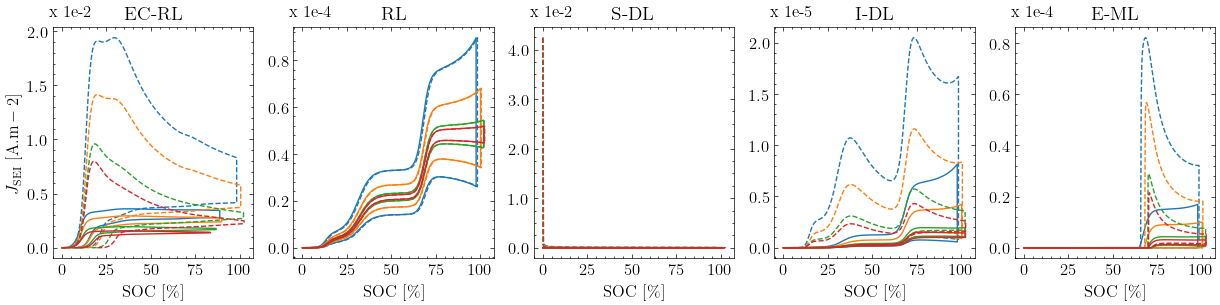

In [6]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.cm as cm
import numpy as np

plt.style.use('science')  # Use the 'science' style
cmap = cm.get_cmap('tab10')  # Colour map (there are many others)

plt.rcParams["font.family"] = "DejaVu Sans"

fig, axs = plt.subplots(1, len(sei_models), figsize=(15, 3))
k = 0
line_styles = ["--", "-"]  # Define line styles

for i, model in enumerate(sei_models):
    for j, c_rate in enumerate(c_rates):
        indices = []
        for cycle in range(0, 2):
            DCh_capacity = (
                (5 - sols[k].cycles[cycle]['Discharge capacity [A.h]'].entries)/5-1) * 100
            J_sei = np.abs(
                sols[k].cycles[cycle]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries)
            axs[i].plot(DCh_capacity, J_sei, linestyle=line_styles[cycle % 2], color=cmap(j),
                        label="Cycle " + str(cycle+1) + ", C /" + str(c_rate))
        k += 1
    axs[i].set_xlabel('SOC [\%]', fontsize=12)
    axs[i].set_title(sei_models_Label[i], fontsize=14)
    current_values = axs[i].get_yticks()
    exponent = np.floor(np.log10(np.max(current_values)))
    scaled_values = current_values / 10**exponent
    axs[i].set_yticklabels(['{:.1f}'.format(y) for y in scaled_values])
    axs[i].text(-0.02, 1.1, 'x 1e{:.0f}'.format(exponent),
                transform=axs[i].transAxes, va='top', ha='left', fontsize=12)
    if i == 0:  # Only set y-label for the first subplot
        axs[i].set_ylabel(
            '$J_{\mathrm{SEI}} \ \mathrm{[A.m-2]} $', fontsize=12)
    # Set the number of ticks on the y-axis and x-axis to 4 or 5
    axs[i].yaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[i].xaxis.set_major_locator(ticker.MaxNLocator(5))
    # Set font size for x-axis ticks
    axs[i].tick_params(axis='x', labelsize=12)
    # Set font size for y-axis ticks
    axs[i].tick_params(axis='y', labelsize=12)
    handles, labels = axs[0].get_legend_handles_labels()
plt.show()